In [2]:
!python -V

Python 3.12.0rc3


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.feature_extraction import DictVectorizer

In [61]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error

In [4]:
df=pd.read_parquet('./data/green_tripdata_2021-01.parquet')
print(df.shape)
df.head()

(76518, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [7]:
display(df.trip_type.value_counts())
print('-'*40)
display(df.trip_type.value_counts(normalize=True))

trip_type
1.0    39233
2.0     1238
Name: count, dtype: int64

----------------------------------------


trip_type
1.0    0.96941
2.0    0.03059
Name: proportion, dtype: float64

In [9]:
#getting trip duration
df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

In [10]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [12]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [15]:
#getting ride pct with certain filter
((df.duration>=1) & (df.duration<=60)).mean()

np.float64(0.9658903787344154)

- 96.5% rides are in this filter

In [16]:
df=df[((df.duration>=1) & (df.duration<=60))]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


### Experiment 1

In [17]:
categorical=['PULocationID','DOLocationID']
numerical=['trip_distance']

In [ ]:
df[categorical]=df[categorical].astype(str)  #converting to string

In [23]:
train_dict=df[categorical+numerical].to_dict(orient='records')
train_dict[:10]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [29]:
dv=DictVectorizer()
X_train= dv.fit_transform(train_dict)

In [30]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [ ]:
dv.feature_names_ #after OHE (One Hot Encoding)

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [33]:
target='duration'
y_train=df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ], shape=(73908,))

In [35]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [36]:
y_pred=lr.predict(X_train)

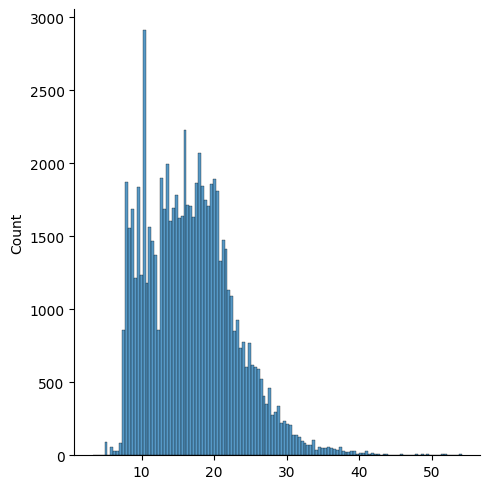

In [ ]:
sns.displot(y_pred,label='prediction')


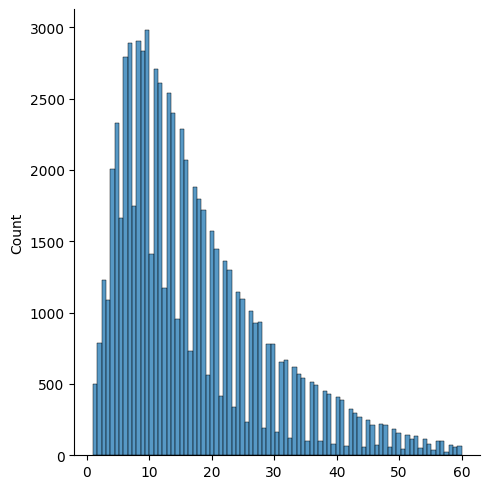

In [41]:
sns.displot(y_train,label='actual')


In [46]:
np.sqrt(mean_squared_error(y_train,y_pred)) #calculate RMSE

np.float64(9.827368941909366)

In [ ]:
def read_dataframe(filename):
    df=pd.read_parquet(filename)

    #getting trip duration
    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

    #filtering
    df=df[((df.duration>=1) & (df.duration<=60))]

    categorical=['PULocationID','DOLocationID']
    numerical=['trip_distance']

    df[categorical]=df[categorical].astype(str)  #converting to string

    return df

In [49]:
df_train=read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val=read_dataframe('./data/green_tripdata_2021-02.parquet')
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [50]:
len(df_train),len(df_val)

(73908, 61921)

In [59]:
dv=DictVectorizer()

train_dict=df_train[categorical+numerical].to_dict(orient='records')
X_train= dv.fit_transform(train_dict)

val_dict=df_val[categorical+numerical].to_dict(orient='records')
X_val= dv.transform(val_dict)


target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [60]:

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(10.496651120494061)

In [ ]:
# lr=Lasso() #12.21
# lr=Lasso(alpha=0.001)  #10.48
lr=Lasso(alpha=0.01)  #10.81
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(10.812725703916977)

In [67]:
# lr=Ridge()  #10.48
# lr=Ridge(alpha=0.001)  #10.48
lr=Ridge(alpha=0.01)  #10.48
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(10.47641000437944)

### Experiment 2

In [ ]:
def read_dataframe_v2(filename):
    df=pd.read_parquet(filename)

    #getting trip duration
    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda td: td.total_seconds()/60)

    #filtering
    df=df[((df.duration>=1) & (df.duration<=60))]

    df['PU_DO']=df['PULocationID'].astype('str')+'_'+df['DOLocationID'].astype('str')

    categorical=['PU_DO']
    numerical=['trip_distance']

    df[categorical]=df[categorical].astype(str)  #converting to string

    return df

In [77]:
df_train=read_dataframe_v2('./data/green_tripdata_2021-01.parquet')
df_val=read_dataframe_v2('./data/green_tripdata_2021-02.parquet')
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [69]:
#generating interaction feature
df_train['PU_DO']=df_train['PULocationID']+'_'+df_train['DOLocationID']  
df_val['PU_DO']=df_val['PULocationID']+'_'+df_val['DOLocationID']
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [ ]:
len(df_train),len(df_val)

(73908, 61921)

In [78]:
categorical=['PU_DO']
numerical=['trip_distance']

dv=DictVectorizer()

train_dict=df_train[categorical+numerical].to_dict(orient='records')
X_train= dv.fit_transform(train_dict)

val_dict=df_val[categorical+numerical].to_dict(orient='records')
X_val= dv.transform(val_dict)


target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [88]:

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(7.758715207732648)

In [ ]:
# lr=Lasso() #12.21
lr=Lasso(alpha=0.001)  #9.2
# lr=Lasso(alpha=0.01)  #11.2
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(12.212583224318818)

In [ ]:
# lr=Ridge()  #7.68
# lr=Ridge(alpha=0.001)  #7.5
lr=Ridge(alpha=0.01)  #7.5
lr.fit(X_train,y_train)

y_pred=lr.predict(X_val)

np.sqrt(mean_squared_error(y_val,y_pred)) #calculate RMSE

np.float64(7.5095411435874455)

In [89]:
import pickle

with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

- prone to error. As all models are names lr.